# Keypoints

Let's demonstrate how to interact with ipython/jupyter notebooks. 

We will :

1. [Download data](#Download-the-data), MEX/HRSC from [PDS Geosciences Node Data and Services: ESA Mars Express Mission - HRSC](http://pds-geosciences.wustl.edu/missions/mars_express/hrsc.htm)
- [Create a virtualenv](#Create-a-Virtualenv) in python as sandbox to play in.
- [Load the data](Load-some-data) and visualize them.
- [Plot the data](#Spectral-Plot) as spectra, because trhe camera has more to show than images.
- Let the [Machine Learn](#Let-the-Machine-learn : play with the data and learn something.

# Download the data

Download HRSC Phobos data from [PDS Geosciences Node Data and Services: ESA Mars Express Mission - HRSC](http://pds-geosciences.wustl.edu/missions/mars_express/hrsc.htm) :

```bash
wget -nc -r ftp://pds-geosciences.wustl.edu/mex/mex-m-hrsc-5-refdr-dtm-v1/mexhrs_2001/data/0360/

[...]
lot of stuff later...
[...]
FINISHED --2017-09-20 15:37:34--
Total wall clock time: 5m 34s
Downloaded: 5 files, 182M in 5m 29s (567 KB/s)

pds-geosciences.wustl.edu
└── mex
    └── mex-m-hrsc-5-refdr-dtm-v1
        └── mexhrs_2001
            └── data
                └── 0360
                    ├── h0360_0000_bl4.img
                    ├── h0360_0000_da4.img
                    ├── h0360_0000_dt4.img
                    ├── h0360_0000_gr4.img
                    ├── h0360_0000_ir4.img
                    ├── h0360_0000_nd4.img
                    └── h0360_0000_re4.img

5 directories, 7 files
```

Due to some strange behaviour under mac the .IMG were converted to GeoTIFF via

```bash
#bash code
for i in `ls *img`
    do gdal_translate -of GTiff $i `basename $i img`tiff
done

ls -l *tiff

26M Sep 20 15:39 h0360_0000_bl4.tiff
52M Sep 20 15:39 h0360_0000_da4.tiff
52M Sep 20 15:39 h0360_0000_dt4.tiff
26M Sep 20 15:39 h0360_0000_gr4.tiff
26M Sep 20 15:39 h0360_0000_ir4.tiff
26M Sep 20 15:39 h0360_0000_re4.tiff
```

# Create a Virtualenv


see [Pipenv & Virtual Environments — The Hitchhiker's Guide to Python](http://docs.python-guide.org/en/latest/dev/virtualenvs/).

This is only for Python>=3!!!!
```bash
python -m venv epsc2017_op_cafe
```

this create locally a tree of directory with a self sufficient python enviroment 


**separated from the system-wide one**


This is **very** useful to not pollute your system and have different version of the same package (see dependency hell)


```bash
tree -lcL 2 epsc2017_op_cafe
epsc2017_op_cafe
├── include
├── lib
│   └── python3.4
├── pyvenv.cfg
└── bin
    ├── python -> /opt/local/bin/python
    ├── python3 -> python
    ├── easy_install
    ├── easy_install-3.4
    ├── pip
    ├── pip3
    ├── pip3.4
    ├── activate
    ├── activate.csh
    └── activate.fish

4 directories, 11 files
```

activate the virtual enviromen and mess here

```bash
source epsc2017_op_cafe/bin/activate
```

install stuff

```bash
python -m pip install scipy scikit-learn blablabla
```

In [1]:
# %load https://gist.githubusercontent.com/kidpixo/13c69055d2f2f5db5585/raw/a4cbb58eae4c14d0bfc84afd82f7dc66856b49af/qgis_script_mario.ipyimport numpy as np
# TODO: %matplotlib inline isn't working!!
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

## Load some data

In [2]:
import os
import gdal
import scipy.ndimage

path = os.path.expanduser('pds-geosciences.wustl.edu/mex/mex-m-hrsc-5-refdr-dtm-v1/mexhrs_2001/data/0360')

fl = []
data, dataSmall = None, None
for file in os.listdir(path):
    if file.endswith(".tiff"):
        fl = fl+[os.path.join(path, file)]
        inDataSource = gdal.Open(fl[-1])
        band = inDataSource.GetRasterBand(1)
        arr = band.ReadAsArray()
        arrSmall = scipy.ndimage.zoom(arr, 0.05, order=3)
        if arr.shape[1] == 2504:
            pass
        if data is not None:
            data = np.dstack((data,arr))
            dataSmall = np.dstack((dataSmall,arrSmall))
        else:
            data = arr
            dataSmall = arrSmall
        print(file, data.shape, dataSmall.shape)
del arr

y_size  , x_size , bands = np.array(data.shape)
ySmall_size  , xSmall_size , bands = np.array(dataSmall.shape)
bandsOrder = [os.path.basename(f).split('.')[0][0:-1].split('_')[-1] for f in fl]

bandsName = [
'Red (750±20 nm)',
'Green ( 530±45 nm)',
'Blue (440±45 nm)',
'IR (970±45 nm)',
]

sortInd = np.array([3,1,0,2])

data = data[:,:,sortInd]
dataSmall = dataSmall[:,:,sortInd]

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


h0360_0000_bl4.tiff (10894, 2504) (545, 125)
h0360_0000_gr4.tiff (10894, 2504, 2) (545, 125, 2)
h0360_0000_ir4.tiff (10894, 2504, 3) (545, 125, 3)
h0360_0000_re4.tiff (10894, 2504, 4) (545, 125, 4)


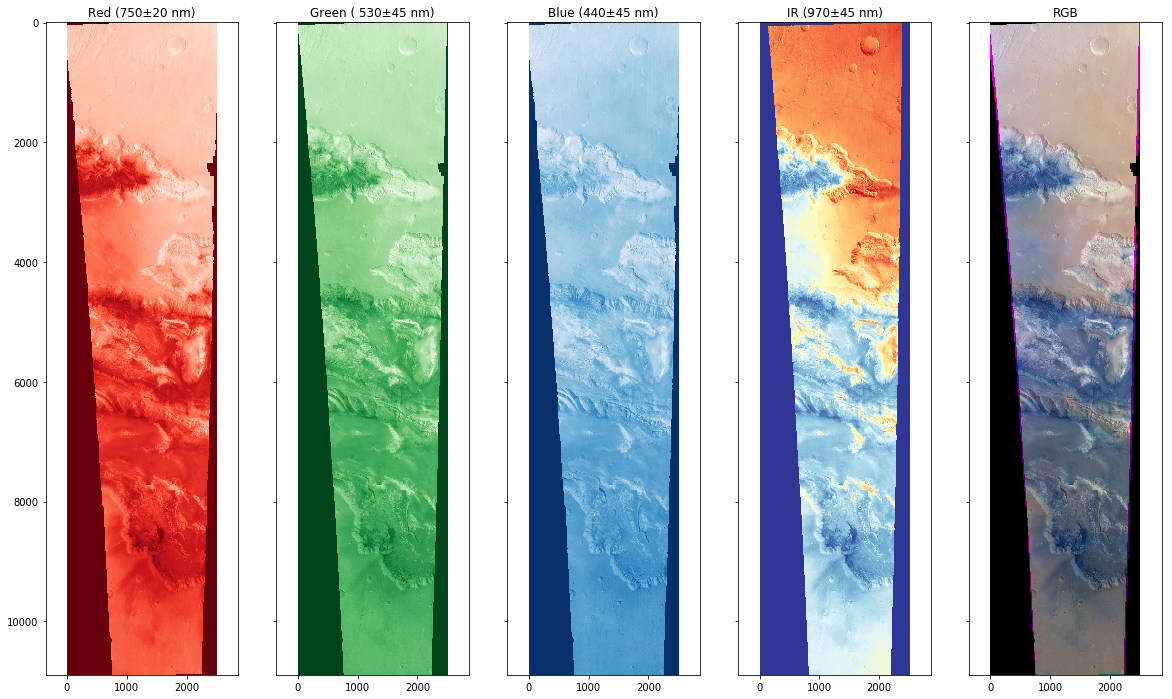

In [6]:
fig, axes = plt.subplots(ncols=bands+1, sharex=True, sharey=True, figsize=[20,12])

#colormaps for    R           G             B                   IR
cms = [plt.cm.Reds_r, plt.cm.Greens_r, plt.cm.Blues_r, plt.cm.RdYlBu_r]

for a,i in zip(axes.flatten()[0:-1],np.arange(data.shape[2])):
    a.imshow(data[:,:,i], cmap=cms[i])
    a.set_title(bandsName[i])
    
axes.flatten()[-1].imshow(data[:,:,0:3])
axes.flatten()[-1].set_title('RGB')

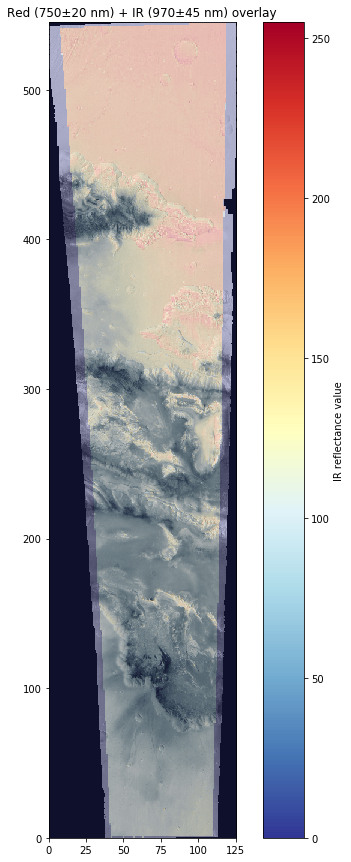

In [4]:
plt.figure(figsize=[10,15])
# np.array([10,200])/0.05,np.array([25,110])/0.05
# plt.imshow(data[20:4000,500:2200,[3,1,0]], extent=(0,85,0,190))
# plt.imshow(dataSmall[10:200,25:110,2],plt.cm.RdYlBu_r, extent=(0,85,0,190), alpha=0.5)
plt.imshow(data[:,:,0]     ,cmap=plt.cm.Greys_r,  extent=(0,dataSmall.shape[1],0,dataSmall.shape[0]))
irplot = plt.imshow(dataSmall[:,:,3],cmap=plt.cm.RdYlBu_r, extent=(0,dataSmall.shape[1],0,dataSmall.shape[0]), alpha=0.3)
color_bar = plt.colorbar(irplot, label = 'IR reflectance value')
color_bar.set_alpha(1)
color_bar.draw_all()
plt.title('%s + %s overlay' % (bandsName[0],bandsName[3]))

# Spectral Plot

The images represent a scene snapshot at a fixed wavelenght. 

As a spectroscopits, I will make it right!


## Select a subset

Let's cut the original huge data to a smaller maneagable region for visualization

```python
dataCut = data[50:4050,500:2200,:]
dataCutSmall.shape
# x, y, spectral
(800, 340, 4)
# number of spectra
dataCut[:,:,0].size
6800000
```

resample it to 10% for Machine Learning to be maneagable on a laptop

```python
import scipy.misc
dataCutSmall = scipy.misc.imresize(dataCut, 0.1, interp='bilinear')
dataCutSmall.shape
# x, y, spectral
(400, 170, 4)
# number of spectra
dataCutSmall[:,:,0].size
68000
```

In [3]:
import scipy.misc
dataCut = data[50:4050,500:2200,:]
dataCutSmall = scipy.misc.imresize(dataCut, 0.1, interp='bilinear')

yCut_size  , xCut_size , bands = np.array(dataCut.shape)
yCutSmall_size  , xCutSmall_size , bands = np.array(dataCutSmall.shape)

del data
del dataSmall

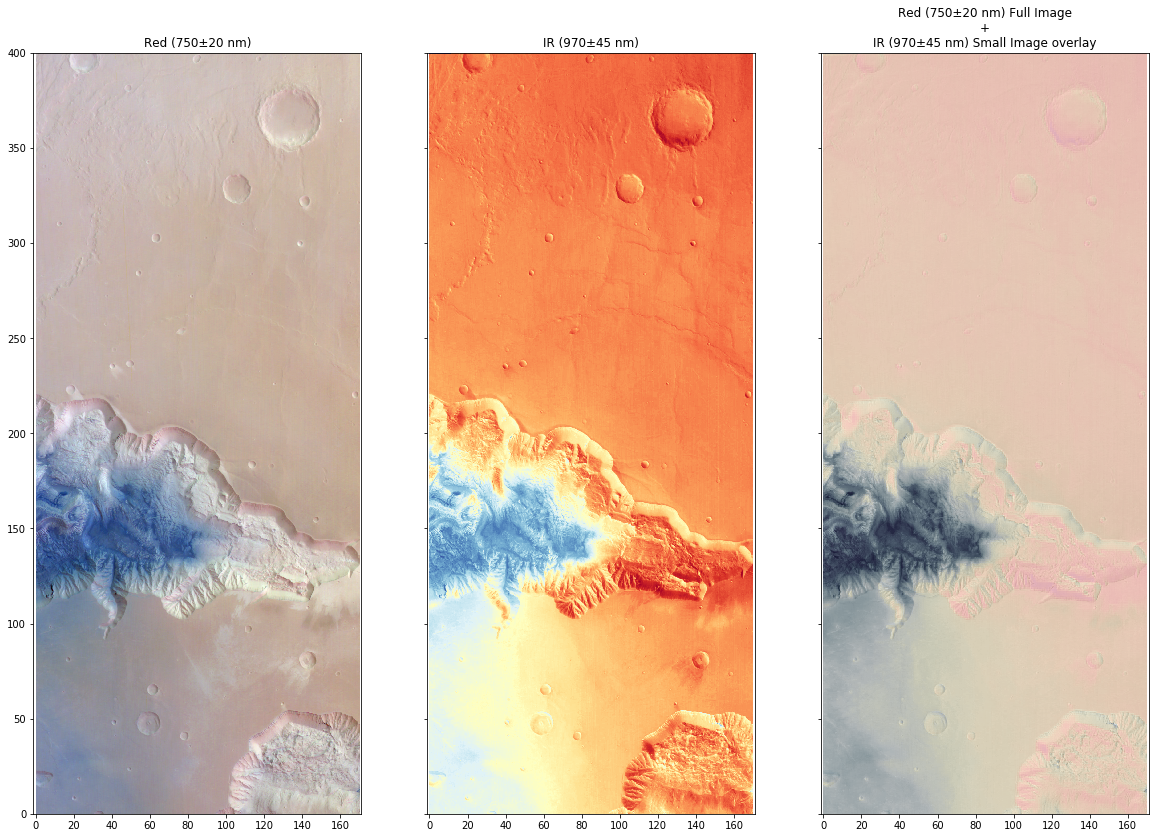

In [7]:
fig, axes = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=[20,14])

axes[0].imshow(dataCut[:,:,0:3], extent=(0,dataCutSmall.shape[1],0,dataCutSmall.shape[0]))
axes[0].set_title(bandsName[0])

axes[1].imshow(dataCut[:,:,3],cmap=plt.cm.RdYlBu_r, extent=(0,dataCutSmall.shape[1],0,dataCutSmall.shape[0]))
axes[1].set_title(bandsName[3])

axes[2].imshow(dataCut[:,:,0],cmap=plt.cm.Greys_r, extent=(0,dataCutSmall.shape[1],0,dataCutSmall.shape[0]))
axes[2].imshow(dataCutSmall[:,:,3],cmap=plt.cm.RdYlBu_r, extent=(0,dataCutSmall.shape[1],0,dataCutSmall.shape[0]), alpha=0.3)
axes[2].set_title('%s Full Image\n+\n%s Small Image overlay' % (bandsName[0],bandsName[3]))

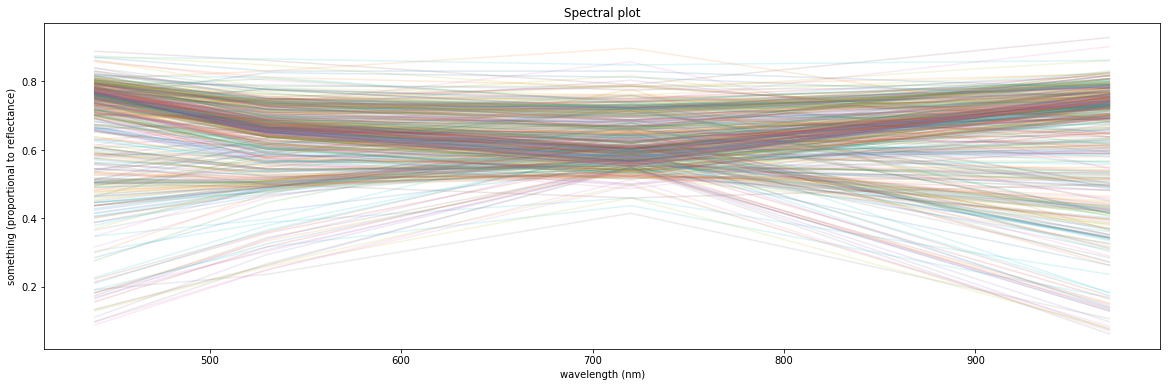

In [42]:
##############
# filter wavelenght from http://sci.esa.int/mars-express/34826-design/?fbodylongid=1597
# Panchromatic (nm) 675±90 Nadir, 2 stereo, 2 photometric
# Red (nm) 750±20 
# Green (nm) 530±45
# Blue (nm) 440±45
# Near-IR (nm) 970±45 
wav = np.array([440.,530.,720.,970.])
##############

dataCutSmallFlt = dataCutSmall.astype('float')
dt_min, dt_max = dataCutSmallFlt.min(),dataCutSmallFlt.max()
dataCutSmallFlt = (dataCutSmallFlt-dt_min)/(dt_max-dt_min)

##############
# reshape the Data collapsing spatial dimension:
#
# dataCutSmallFlt.shape
# (545, 125, 4)
#
plotData = dataCutSmallFlt.reshape(-1, dataCutSmall.shape[-1])
# 
# plotData.shape
# (68125, 4)
##############
# randomly select a subset of the spectra
plotDataSampled = plotData[np.random.randint(plotData.shape[0], size=500), :]
# plotData.shape
#
# (500, 4)
##############
# Iterate over the 0-th dimension
# for sp in np.rollaxis(array,0).shape:
#     print(sp.shape)
#
# (4)
#
##############

fig = plt.figure(figsize=[20,6])
for sp in np.rollaxis(plotDataSampled,0):
    plt.plot(wav, sp, alpha=0.15);
plt.title('Spectral plot')
plt.ylabel('something (proportional to reflectance)');
plt.xlabel('wavelength (nm)');

## Let the Machine learn

Apply some ML from the fantastic [scikit-learn: machine learning in Python — scikit-learn 0.19.0](http://scikit-learn.org/stable/) packet.

In particular, see :

1. [4.3. Preprocessing data — scikit-learn 0.19.0 documentation](http://scikit-learn.org/stable/modules/preprocessing.html)
- [2.5. Decomposing signals in components (matrix factorization problems) — scikit-learn 0.19.0 documentation](http://scikit-learn.org/stable/modules/decomposition.html)
- [2.3. Clustering — scikit-learn 0.19.0 documentation](http://scikit-learn.org/stable/modules/clustering.html)
- [2.2. Manifold learning — scikit-learn 0.19.0 documentation](http://scikit-learn.org/stable/modules/manifold.html)

In [166]:
######################
# Decomposition
######################

mlData = np.rollaxis(plotData,0)

from sklearn.decomposition import PCA, FastICA

# Randomized Principal components analysis: which is the data dimensionality?

pca = PCA(svd_solver='randomized',n_components=4)
pca.fit(mlData)

mlDataPCA = pca.fit_transform(mlData)

print("PCA explained Variance")
print("                 variance     var_ratio   cum_var_ratio")
for i in range(pca.n_components):
    print("Component %2s: %10f   %10f   %10f" % (i, pca.explained_variance_[i], pca.explained_variance_ratio_[i], np.cumsum(pca.explained_variance_ratio_)[i]))
    

PCA explained Variance
                 variance     var_ratio   cum_var_ratio
Component  0:   0.067852     0.918611     0.918611
Component  1:   0.005485     0.074261     0.992872
Component  2:   0.000373     0.005052     0.997924
Component  3:   0.000153     0.002076     1.000000


[(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]


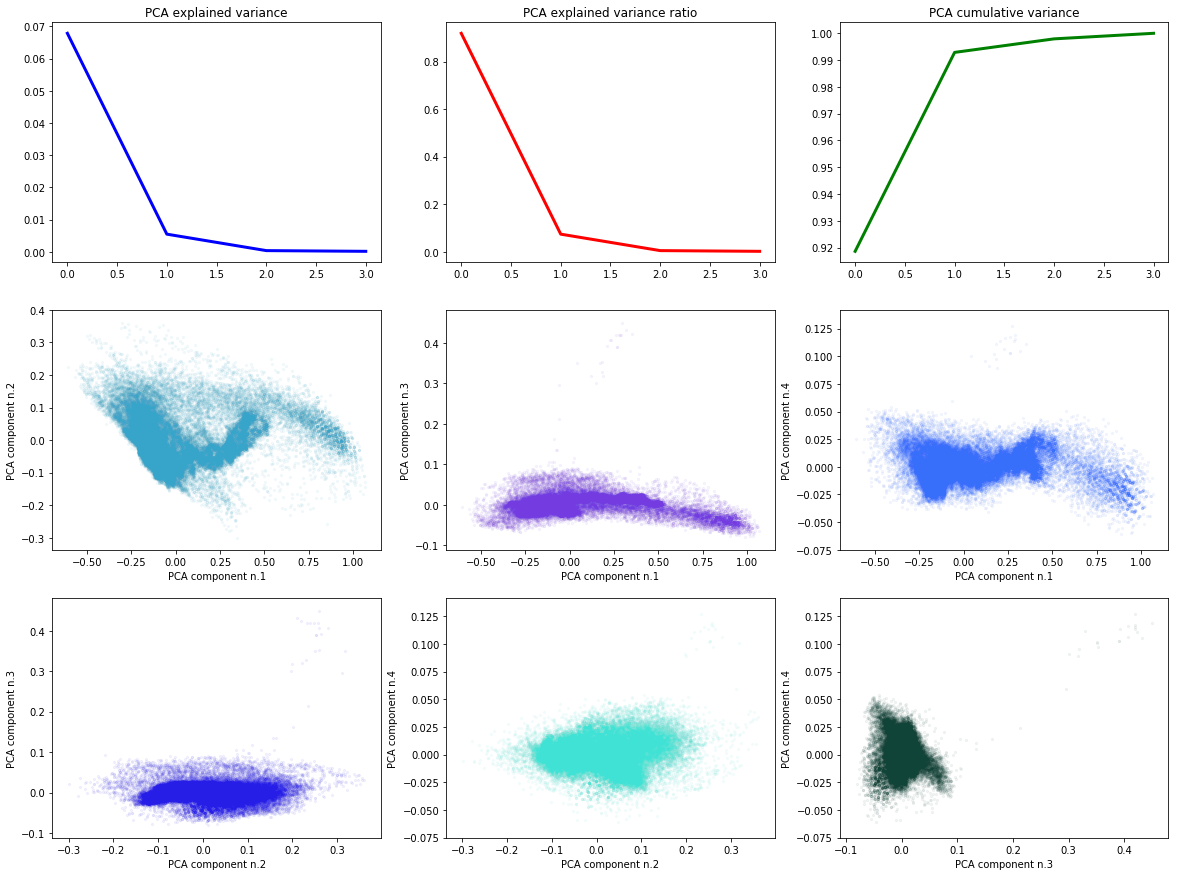

In [7]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=[20,15])
axes = axes.flatten()

ind = 0
axes[ind].plot(np.arange(pca.n_components), pca.explained_variance_,label='explained variance',c='b',linewidth=3 )
axes[ind].set_title("PCA explained variance");

ind += 1
axes[ind].plot(np.arange(pca.n_components), pca.explained_variance_ratio_,label='explained variance ratio', c='r',linewidth=3 )
axes[ind].set_title("PCA explained variance ratio");

ind += 1
axes[ind].plot(np.arange(pca.n_components), np.cumsum(pca.explained_variance_ratio_),c='g',linewidth=3 )
axes[ind].set_title("PCA cumulative variance");

def plot_pca_comp(pdata,ax ,ind,x,y):
    ind += 1
    axes[ind].scatter(pdata[:, x], pdata[:, y], marker='o', alpha=0.05, c=np.random.rand(3,), s = 5)
    axes[ind].set_xlabel('PCA component n.{:d}'.format(x+1))
    axes[ind].set_ylabel('PCA component n.{:d}'.format(y+1))
    return ind

import itertools

print(list(itertools.combinations([0,1,2,3],2)))

for x,y in itertools.combinations([0,1,2,3],2):
    ind = plot_pca_comp(mlDataPCA,axes,ind,x,y)

In [85]:
import sklearn.cluster
import sklearn.preprocessing
from sklearn.pipeline import Pipeline, FeatureUnion

n_clusters = 5
estimators = [
              ('prePCA', PCA(n_components=3)),
              ('preStandard',sklearn.preprocessing.StandardScaler()),
#              ('preMinMax', sklearn.preprocessing.MinMaxScaler()),
              ('clsKMeans', sklearn.cluster.KMeans(n_clusters=n_clusters))
              ]
pipe = Pipeline(estimators)

labels =  pipe.fit_predict(mlData)

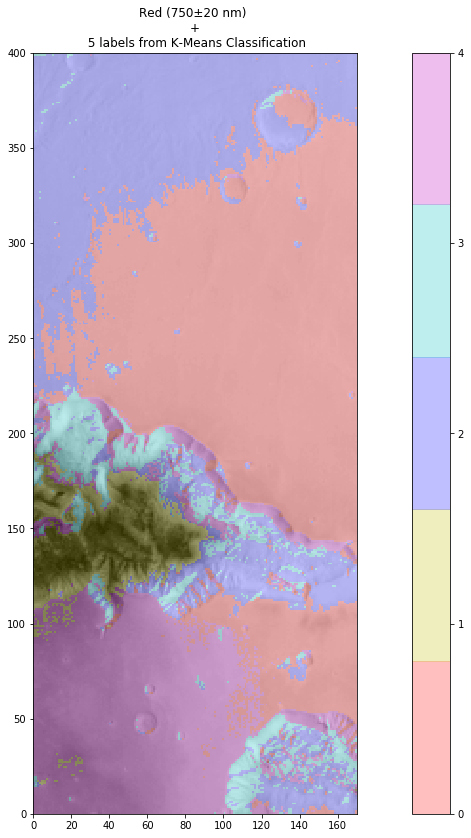

In [172]:
fig, axes = plt.subplots(sharex=True, sharey=True, figsize=[20,14])

# Define our own color map with ListedColormap
# see [python - Custom Colormap using Matplotlib.image - Stack Overflow](https://stackoverflow.com/a/42809352/1435167)

mplColors = ['r', 'y', 'b', 'c', 'm', 'g', 'k', 'w']
clist =  mplColors[0:len(np.unique(labels))]
cmap = matplotlib.colors.ListedColormap(clist)

axes.imshow(dataCutSmall[:,:,0],cmap=plt.cm.Greys_r, extent=(0,dataCutSmall.shape[1],0,dataCutSmall.shape[0]))
lblshow = axes.imshow(labels.reshape(dataCutSmallFlt.shape[0:2]),cmap=cmap, extent=(0,dataCutSmall.shape[1],0,dataCutSmall.shape[0]), alpha=0.25)
plt.colorbar(ax=axes,mappable=lblshow, ticks= np.arange(n_clusters))
axes.set_title('%s \n+\n %s labels from K-Means Classification' % (bandsName[0],n_clusters))

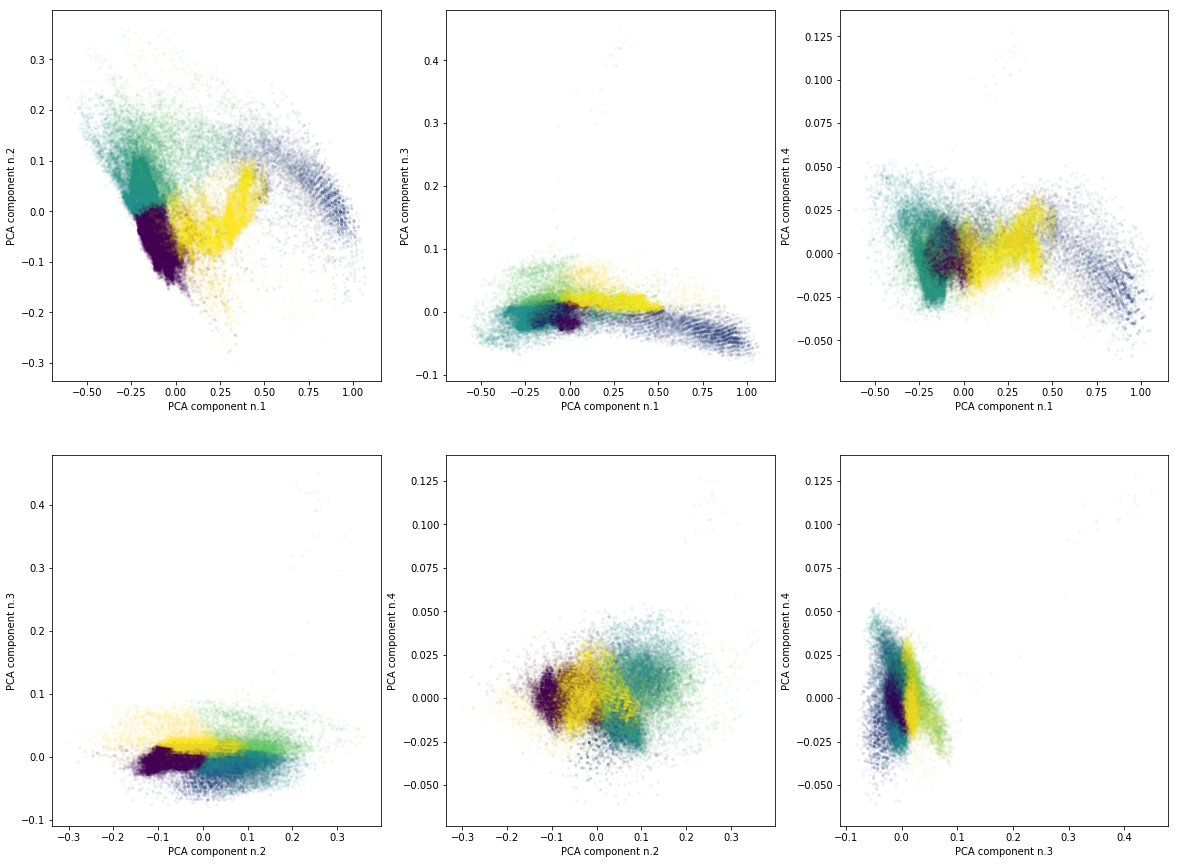

In [87]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=[20,15])
axes = axes.flatten()


def plot_pca_comp(pdata,ax ,ind,x,y):
    ind += 1
    axes[ind].scatter(pdata[:, x], pdata[:, y], marker='o', alpha=0.05, c=labels, s = 5)
    axes[ind].set_xlabel('PCA component n.{:d}'.format(x+1))
    axes[ind].set_ylabel('PCA component n.{:d}'.format(y+1))
    return ind

ind = -1
for x,y in itertools.combinations(range(4),2):
    ind = plot_pca_comp(mlDataPCA,axes,ind,x,y)

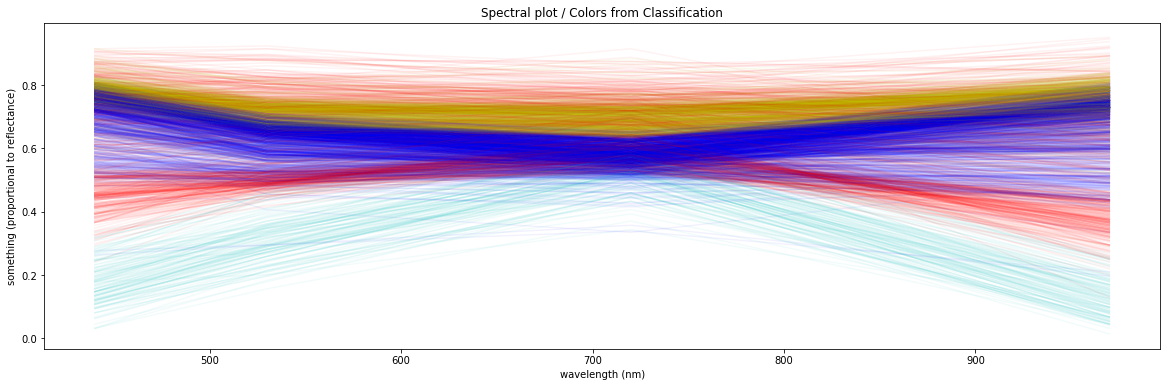

In [61]:
random_ind = np.random.randint(plotData.shape[0], size=2500)

plotDataSampled = plotData[random_ind, :]
labelsSamples = labels[random_ind]

mplColors = ['r', 'y', 'b', 'c', 'm', 'g', 'k', 'w']
clist =  mplColors[0:len(np.unique(labels))]
cmap = matplotlib.colors.ListedColormap(clist)


fig = plt.figure(figsize=[20,6])
for sp, la in zip(np.rollaxis(plotDataSampled,0),labelsSamples):
    plt.plot(wav, sp, alpha=0.05, color=cmap(la));
plt.title('Spectral plot / Colors from Classification')
plt.ylabel('something (proportional to reflectance)');
plt.xlabel('wavelength (nm)');

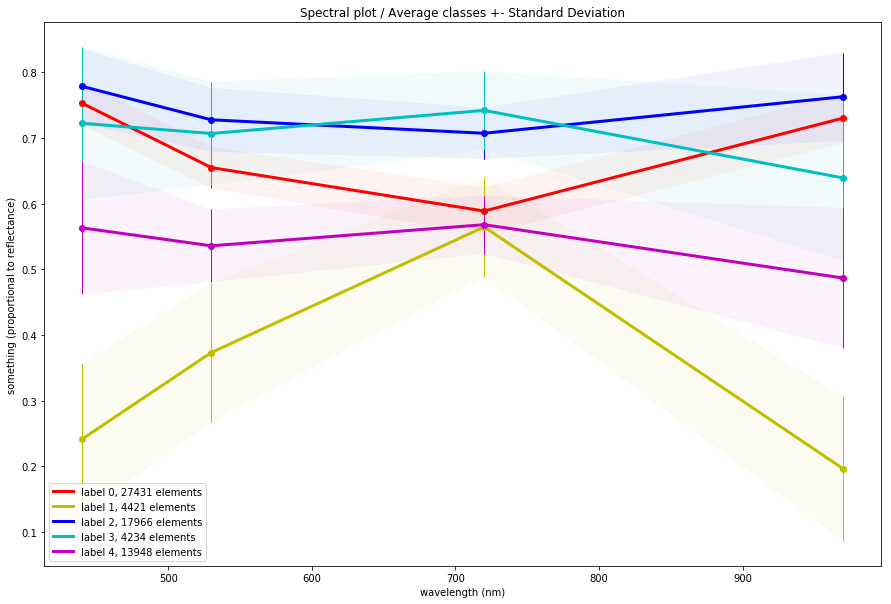

In [153]:
fig = plt.figure(figsize=[15,10])

for i in np.unique(labels):
    sp_mean = np.mean(plotData[labels == i,:],axis=0)
    sp_std = np.std(plotData[labels == i,:],axis=0)
    plt.plot(wav, sp_mean, lw=3, color=cmap(i),label='label %s, %s elements' % (i,np.sum(labels == i)));
    plt.errorbar(wav, sp_mean, lw=1, color=cmap(i), yerr=sp_std , fmt='o');
    plt.fill_between(wav, sp_mean-sp_std, sp_mean+sp_std, facecolor=cmap(i), alpha=0.05)
    plt.title('Spectral plot / Average classes +- Standard Deviation')
    plt.ylabel('something (proportional to reflectance)');
    plt.xlabel('wavelength (nm)');
    plt.legend(loc='best')

## Miscellaneous

To get a sense of the data sctructure, we can try to apply Manifold learning or 

> "an approach to non-linear dimensionality reduction.
>
> Algorithms for this task are based on the idea that the 
>
> dimensionality of many data sets is only artificially high."

see [ Manifold learning — scikit-learn 0.19.0 documentation](http://scikit-learn.org/stable/modules/manifold.html#spectral-embedding).


In [160]:
%%time
import sklearn.manifold

random_ind = np.random.randint(plotData.shape[0], size=5000)

mlDataSampled = mlData [random_ind, :]
labelsSamples = labels [random_ind]


mlDataSampled_embedded = sklearn.manifold.SpectralEmbedding(n_components=2).fit_transform(mlDataSampled)
print(mlDataSampled_embedded.shape)

(5000, 2)
CPU times: user 8.51 s, sys: 360 ms, total: 8.87 s
Wall time: 8.83 s


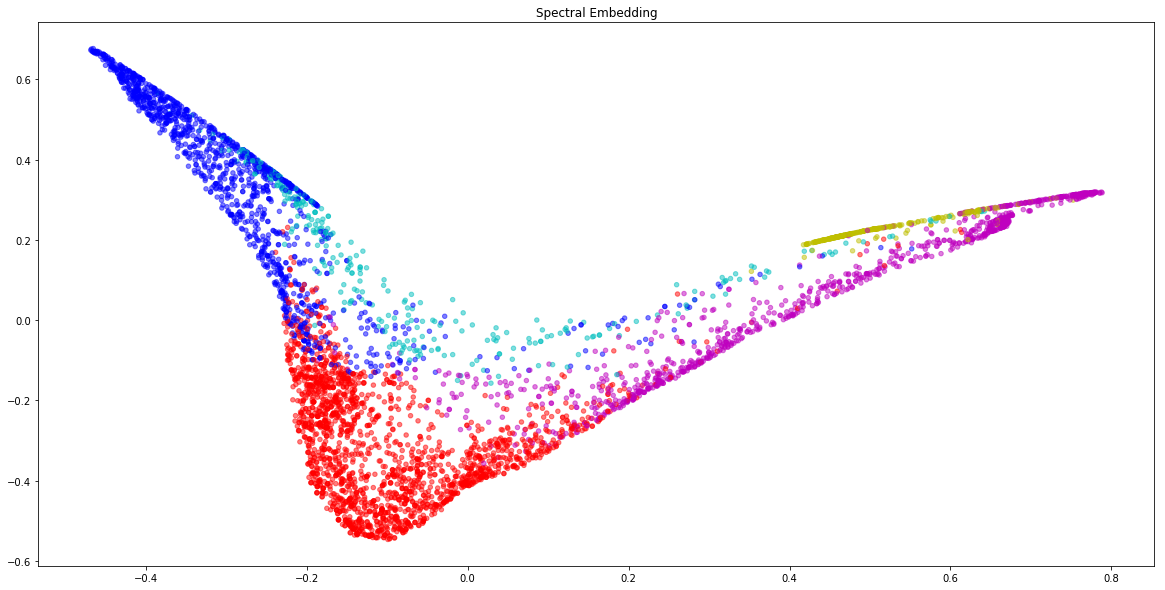

In [161]:
plt.figure(figsize=[20,10])
plt.scatter(mlDataSampled_embedded[:,0],mlDataSampled_embedded[:,1], marker='o', alpha=0.5, s = 20, c=cmap(labelsSamples))
plt.title('Spectral Embedding')

In [164]:
# time consuming!!!
%time 
import sklearn.manifold

random_ind = np.random.randint(plotData.shape[0], size=500)

mlDataSampled = mlData[random_ind, :]
labelsSamples = labels[random_ind]


mlDataSampled_embedded = sklearn.manifold.TSNE(n_components=2).fit_transform(mlDataSampled)
print(mlDataSampled_embedded.shape)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 6.91 µs
(500, 2)


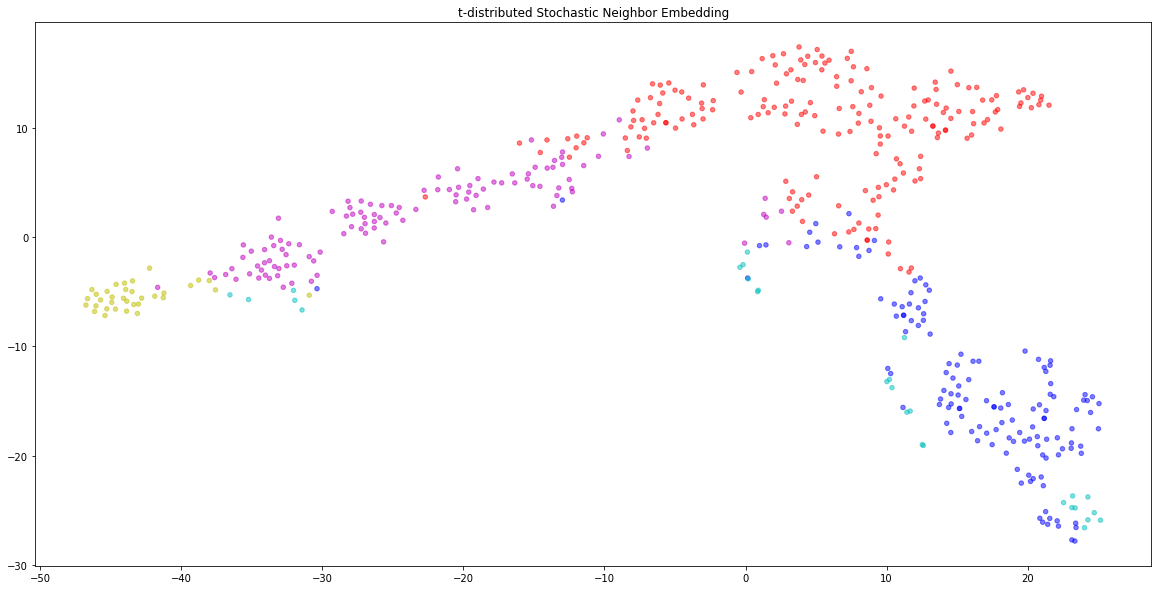

In [165]:
plt.figure(figsize=[20,10])
plt.scatter(mlDataSampled_embedded[:,0],mlDataSampled_embedded[:,1], marker='o', alpha=0.5, s = 20, c=cmap(labelsSamples))
plt.title('t-distributed Stochastic Neighbor Embedding')